In [1]:
import os
import cv2
import pandas as pd
import numpy as np
CSV_PATH = "NeoJaundice/chd_jaundice_published_2.csv"
IMG_DIR = "NeoJaundice/images"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        image_data.append(img)
        labels.append(row["blood(mg/dL)"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['patient_id', 'image_idx', 'gender', 'gestational_age', 'age(day)',
       'weight', 'blood(mg/dL)', 'Treatment'],
      dtype='object')
Loaded 2235 images.


In [2]:
def extract_yellow_card(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 100])  
    upper_yellow = np.array([30, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        yellow_card = img[y:y+h, x:x+w]
        return yellow_card
    else:
        return None  


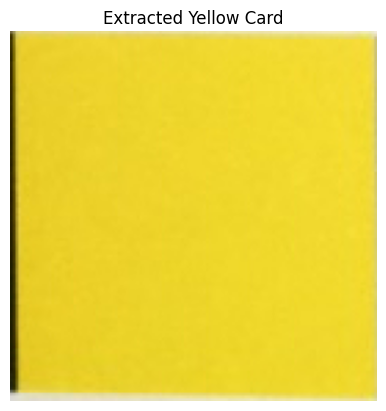

In [3]:
sample_card = extract_yellow_card(image_data[138])
if sample_card is not None:
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(sample_card, cv2.COLOR_BGR2RGB))
    plt.title("Extracted Yellow Card")
    plt.axis('off')
    plt.show()
else:
    print("Yellow card not detected in this image.")

In [4]:
def compute_lab_means(lab_img):
    L, A, B = cv2.split(lab_img)
    return np.mean(L), np.mean(A), np.mean(B)

def correct_image_color(full_img, yellow_card_img):
    lab_full = cv2.cvtColor(full_img, cv2.COLOR_BGR2LAB)
    lab_card = cv2.cvtColor(yellow_card_img, cv2.COLOR_BGR2LAB)
    
    L_card_mean, A_card_mean, B_card_mean = compute_lab_means(lab_card)
    target_L, target_A, target_B = 207.0, 121.0, 209.0  
    
    delta_L = target_L - L_card_mean
    delta_A = target_A - A_card_mean
    delta_B = target_B - B_card_mean
    
    L_full, A_full, B_full = cv2.split(lab_full)
    L_full = np.clip(L_full + delta_L, 0, 255)
    A_full = np.clip(A_full + delta_A, 0, 255)
    B_full = np.clip(B_full + delta_B, 0, 255)

    corrected_lab = cv2.merge([L_full, A_full, B_full]).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)
    
    return corrected_bgr


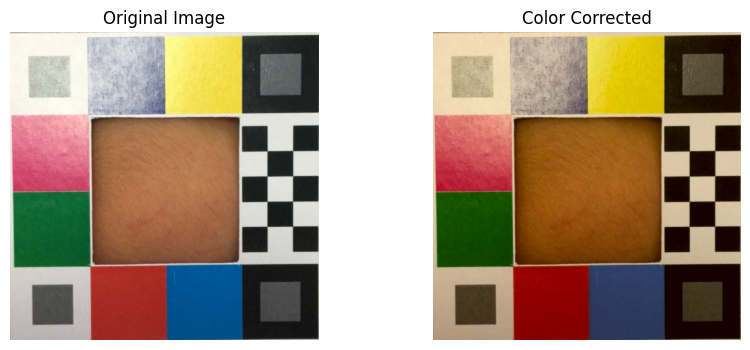

In [5]:
img = image_data[394]
yellow_card = extract_yellow_card(img)
if yellow_card is not None:
    corrected_img = correct_image_color(img, yellow_card)


    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
    plt.title("Color Corrected")
    plt.axis('off')
    plt.show()
else:
    print("Yellow card not found.")


In [6]:
def extract_skin_roi(image, roi_fraction=0.35):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi


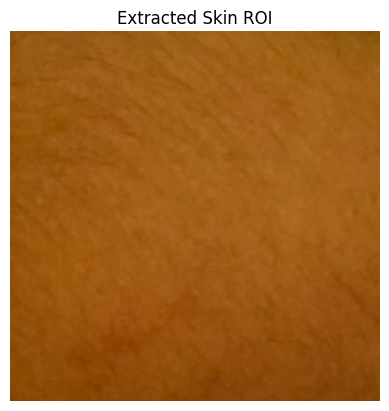

In [7]:
skin_roi = extract_skin_roi(corrected_img)

plt.imshow(cv2.cvtColor(skin_roi, cv2.COLOR_BGR2RGB))
plt.title("Extracted Skin ROI")
plt.axis("off")
plt.show()


In [8]:
import cv2
import numpy as np

def extract_color_spaces(img):
    img_resized = cv2.resize(img, (128, 128))
    rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb) 
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    
    rgb_seq = rgb.reshape(-1, 3)
    hsv_seq = hsv.reshape(-1, 3)
    ycbcr_seq = ycbcr.reshape(-1, 3)
    lab_seq = lab.reshape(-1, 3)
    
    return rgb_seq, hsv_seq, ycbcr_seq, lab_seq


In [9]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    yellow_card = extract_yellow_card(img)
    corrected_img = correct_image_color(img, yellow_card)
    skin_roi = extract_skin_roi(corrected_img)
    return extract_color_spaces(skin_roi)

In [10]:
processed_hsv = []
processed_ycbcr = []
processed_lab = []
processed_rgb = []
processed_labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    try:
        hsv, ycbcr, lab, rgb = preprocess_image(img_path)  
        processed_hsv.append(hsv)
        processed_ycbcr.append(ycbcr)
        processed_lab.append(lab)
        processed_rgb.append(rgb)
        processed_labels.append(row["blood(mg/dL)"]) 
    except Exception as e:
        print(f"Skipping {img_path} due to preprocessing error: {e}")
        continue

processed_hsv = np.array(processed_hsv)
processed_ycbcr = np.array(processed_ycbcr)
processed_lab = np.array(processed_lab)
processed_rgb = np.array(processed_rgb)
processed_labels = np.array(processed_labels)

print("Processed HSV shape:", processed_hsv.shape)
print("Processed labels shape:", processed_labels.shape)

print(rgb[0])
print(hsv[0])
print(lab[0])


Skipping NeoJaundice/images\0101-2.jpg due to preprocessing error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Skipping NeoJaundice/images\0455-3.jpg due to preprocessing error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Skipping NeoJaundice/images\0842-3.jpg due to preprocessing error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Skipping NeoJaundice/images\0954-3.jpg due to preprocessing error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Processed HSV shape: (2231, 16384, 3)
Processed labels shape: (2231,)
[142 145 1

In [13]:
def flatten_for_scaler(data):
    return data.reshape(data.shape[0], -1)

def reshape_for_cnn(data):
    return data.reshape(data.shape[0], 3,16384)

rgb_flat = flatten_for_scaler(processed_rgb)
hsv_flat = flatten_for_scaler(processed_hsv)
ycbcr_flat = flatten_for_scaler(processed_ycbcr)
lab_flat = flatten_for_scaler(processed_lab)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

rgb_flat_scaled = scaler.fit_transform(rgb_flat)
hsv_flat_scaled = scaler.fit_transform(hsv_flat)
ycbcr_flat_scaled = scaler.fit_transform(ycbcr_flat)
lab_flat_scaled = scaler.fit_transform(lab_flat)

rgb_scaled = reshape_for_cnn(rgb_flat_scaled)
hsv_scaled = reshape_for_cnn(hsv_flat_scaled)
ycbcr_scaled = reshape_for_cnn(ycbcr_flat_scaled)
lab_scaled = reshape_for_cnn(lab_flat_scaled)


In [15]:
from sklearn.model_selection._split import train_test_split
rgb_train, rgb_temp, hsv_train, hsv_temp, ycbcr_train, ycbcr_temp, lab_train, lab_temp, y_train, y_temp = train_test_split(
    rgb_scaled, hsv_scaled, ycbcr_scaled, lab_scaled, processed_labels, test_size=0.3, random_state=42)

rgb_val,rgb_test,hsv_val, hsv_test, ycbcr_val, ycbcr_test, lab_val, lab_test, y_val, y_test = train_test_split(
    rgb_temp,hsv_temp, ycbcr_temp, lab_temp, y_temp, test_size=0.67, random_state=4)

In [16]:
print(processed_rgb.shape)
print(rgb_scaled.shape)
print(rgb_flat_scaled.shape)

(2231, 16384, 3)
(2231, 3, 16384)
(2231, 49152)


In [17]:
print(rgb_train.shape)
print(rgb_val.shape)
print(rgb_test.shape)

(1561, 3, 16384)
(221, 3, 16384)
(449, 3, 16384)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras import initializers
l2_lambda = 0.001 
# initializer = tf.keras.initializers.GlorotNormal() 
def build_rgb_1d_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling1D(pool_size=2 , padding='same'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(l2_lambda)))  

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

input_shape = rgb_train.shape[1:]  
model = build_rgb_1d_cnn(input_shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             1572896   
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 128)            0

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6,verbose=1)
]

history = model.fit(
    rgb_train, y_train,
    validation_data=(rgb_val, y_val),
    epochs=150,
    batch_size=32,
    verbose=2,
    callbacks=callbacks
)


Epoch 1/150
49/49 - 3s - loss: 63.4040 - mae: 6.4522 - val_loss: 25.3632 - val_mae: 4.2692 - lr: 1.0000e-04 - 3s/epoch - 68ms/step
Epoch 2/150
49/49 - 2s - loss: 33.3144 - mae: 4.6670 - val_loss: 23.8002 - val_mae: 4.1670 - lr: 1.0000e-04 - 2s/epoch - 38ms/step
Epoch 3/150
49/49 - 2s - loss: 30.2725 - mae: 4.4919 - val_loss: 21.1805 - val_mae: 3.9133 - lr: 1.0000e-04 - 2s/epoch - 35ms/step
Epoch 4/150
49/49 - 2s - loss: 26.3653 - mae: 4.1321 - val_loss: 19.7638 - val_mae: 3.6640 - lr: 1.0000e-04 - 2s/epoch - 37ms/step
Epoch 5/150
49/49 - 2s - loss: 23.3781 - mae: 3.8452 - val_loss: 19.2009 - val_mae: 3.5496 - lr: 1.0000e-04 - 2s/epoch - 38ms/step
Epoch 6/150
49/49 - 2s - loss: 22.4373 - mae: 3.7288 - val_loss: 19.8826 - val_mae: 3.5678 - lr: 1.0000e-04 - 2s/epoch - 33ms/step
Epoch 7/150
49/49 - 2s - loss: 22.0815 - mae: 3.6416 - val_loss: 17.5828 - val_mae: 3.4167 - lr: 1.0000e-04 - 2s/epoch - 31ms/step
Epoch 8/150
49/49 - 2s - loss: 22.1292 - mae: 3.6935 - val_loss: 23.3070 - val_mae:

In [20]:
test_loss, test_mae = model.evaluate(rgb_test, y_test, verbose=2)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict(rgb_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}")
print(f"R^2: {r2:.3f}")


15/15 - 0s - loss: 16.1352 - mae: 3.1236 - 89ms/epoch - 6ms/step
Test Loss (MSE): 16.135231018066406
Test MAE: 3.1235952377319336
15/15 [==============================] - 0s 3ms/step
RMSE: 3.964
R^2: 0.347


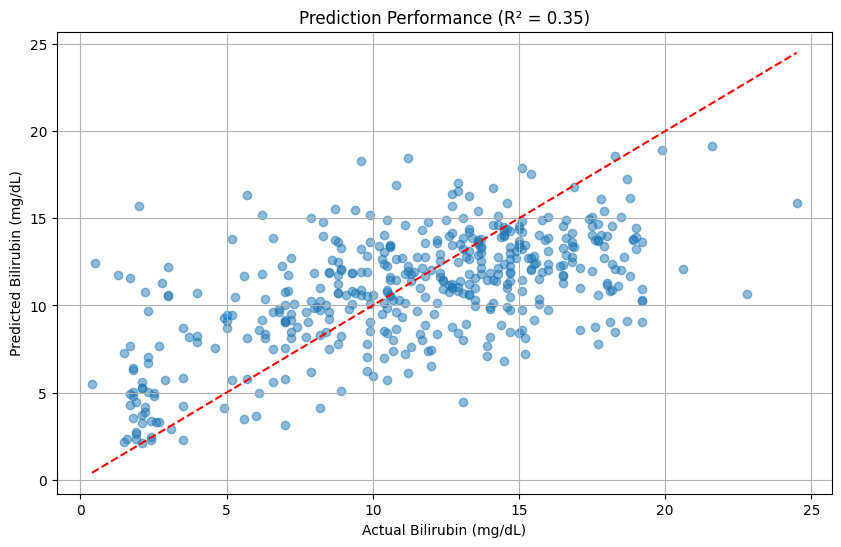

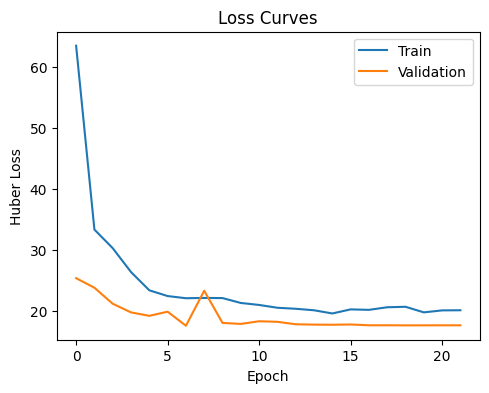

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.grid(True)
plt.show()

# --- Plot Training History ---
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()